# A/B testing
## Step 1: loading data and explore structure

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import beta
from tabulate import tabulate


In [2]:
control = pd.read_csv("control_group.csv",delimiter=";")
test = pd.read_csv("test_group.csv",delimiter=";")
control.shape


(30, 10)

In [3]:
test.shape


(30, 10)

In [4]:
control.head()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [6]:
#Check NA
control.isna().sum()


Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [7]:
test.isna().sum()


Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

In [8]:
control = control.fillna(method="bfill")
control.isna().sum()


/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_58652/99132336.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  control = control.fillna(method="bfill")


Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

In [9]:
new_names = ['Campaign Name', 'Date', 'Spend', 'Impressions', 'Reach',
       'Website Clicks', 'Searches', 'View Content',
       'Add to Cart', 'Purchase']
control_columns = [x + "_control" if x!="Date" else x for x in new_names ]

columns_map = dict(zip(control.columns,control_columns))

control = control.rename(columns=columns_map)

test_columns = [x + "_test" if x!="Date" else x for x in new_names ]

columns_map_test = dict(zip(test.columns,test_columns))

test = test.rename(columns=columns_map_test)


In [10]:
df = control.merge(test,how="inner",on="Date")


## Step 2 Creating metrics

### Success Metrics:

In [11]:
# --- Success Metrics (Expect Improvement) ---

## Purchase Rate
df['Purchase Rate (Content Viewed to Purchase)_control'] = (
    df['Purchase_control'] / df['View Content_control'] * 100
)
df['Purchase Rate (Content Viewed to Purchase)_test'] = (
    df['Purchase_test'] / df['View Content_test'] * 100
)

## Conversion Rate
df['Conversion Rate_control'] = (
    df['Purchase_control'] / df['Website Clicks_control'] * 100
)
df['Conversion Rate_test'] = (
    df['Purchase_test'] / df['Website Clicks_test'] * 100
)


### Guardrail metric:


In [12]:
# --- Guardrail Metrics (No Worsening Allowed) ---

## add to cart rate 
df['Add-to-Cart Rate_control'] = (
    df['Add to Cart_control'] / df['View Content_control'] * 100
)
df['Add-to-Cart Rate_test'] = (
    df['Add to Cart_test'] / df['View Content_test'] * 100
)


df['Bounce Rate_control'] = (
    100 - df['Website Clicks_control'] / df['Impressions_control'] * 100
)
df['Bounce Rate_test'] = (
    100 - df['Website Clicks_test'] / df['Impressions_test'] * 100
)

df['Page Load Time​_control'] = np.random.uniform(0, 5, len(df))  # Example data
df['Page Load Time​_test'] = np.random.uniform(0, 5, len(df)) 

### Deterioration metrics

In [13]:
# --- Deterioration Metrics (Must Not Degrade) ---
# Deterioration Metric Calculation

def calc_deterioration(df, metric_column_control, metric_column_test):
    """
    Calculate the daily deterioration metric for both control and test groups.
    Deterioration is defined as the percentage change in the metric from the previous day.
    """
    # Control group deterioration
    deterioration_control = df[metric_column_control].pct_change() * 100
    # Test group deterioration
    deterioration_test = df[metric_column_test].pct_change() * 100
    return deterioration_control, deterioration_test
 

# Calculating deterioration in Conversion Rate for both control and test groups
deterioration_control, deterioration_test = calc_deterioration(
    df, 'Conversion Rate_control', 'Conversion Rate_test'
)

df['deterioration_control'] = deterioration_control

df['deterioration_test'] = deterioration_test

## Click-Through Rate
df['Click-Through Rate (CTR)_control'] = (
    df['Website Clicks_control'] / df['Impressions_control'] * 100
)
df['Click-Through Rate (CTR)_test'] = (
    df['Website Clicks_test'] / df['Impressions_test'] * 100
)


#print(f"Control Group Conversion Rate Deterioration: {deterioration_control:.2f}%")
#print(f"Test Group Conversion Rate Deterioration: {deterioration_test:.2f}%")


The control group experience a slightly higher increase in conversion rates compared to the test group. This would suggest that the changes applied to the test group were not effective in boosting conversions.

### Quality metrics 


In [14]:
def sample_ratio_mismatch(control_size, test_size, alpha=0.05):
    total = control_size + test_size
    expected_ratio = 0.5  

    
    chi2, p = stats.chisquare([control_size, test_size], f_exp=[total / 2, total / 2])
    return p < alpha


control_size = len(control)
test_size = len(test)
srm_flag = sample_ratio_mismatch(control_size, test_size)

if srm_flag:
    print("Warning: Sample Ratio Mismatch detected!")
else:
    print("No Sample Ratio Mismatch detected.")


No Sample Ratio Mismatch detected.



--- One-Sided Test Results (with Bonferroni Correction) ---

Success Metrics:
Purchase Rate (Content Viewed to Purchase)_control vs Purchase Rate (Content Viewed to Purchase)_test: t-statistic = -0.5654, p-value = 0.7119, Not Significant
Conversion Rate_control vs Conversion Rate_test: t-statistic = -1.6807, p-value = 0.9482, Not Significant

Guardrail Metrics:
Add-to-Cart Rate_control vs Add-to-Cart Rate_test: t-statistic = -3.1910, p-value = 0.9983, Not Significant
Bounce Rate_control vs Bounce Rate_test: t-statistic = -4.0351, p-value = 0.9998, Not Significant
Page Load Time​_control vs Page Load Time​_test: t-statistic = -0.3668, p-value = 0.6418, Not Significant

Deterioration Metrics:
deterioration_control vs deterioration_test: t-statistic = -0.2039, p-value = 0.4200, Not Significant
Click-Through Rate (CTR)_control vs Click-Through Rate (CTR)_test: t-statistic = 4.0351, p-value = 0.9998, Not Significant


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


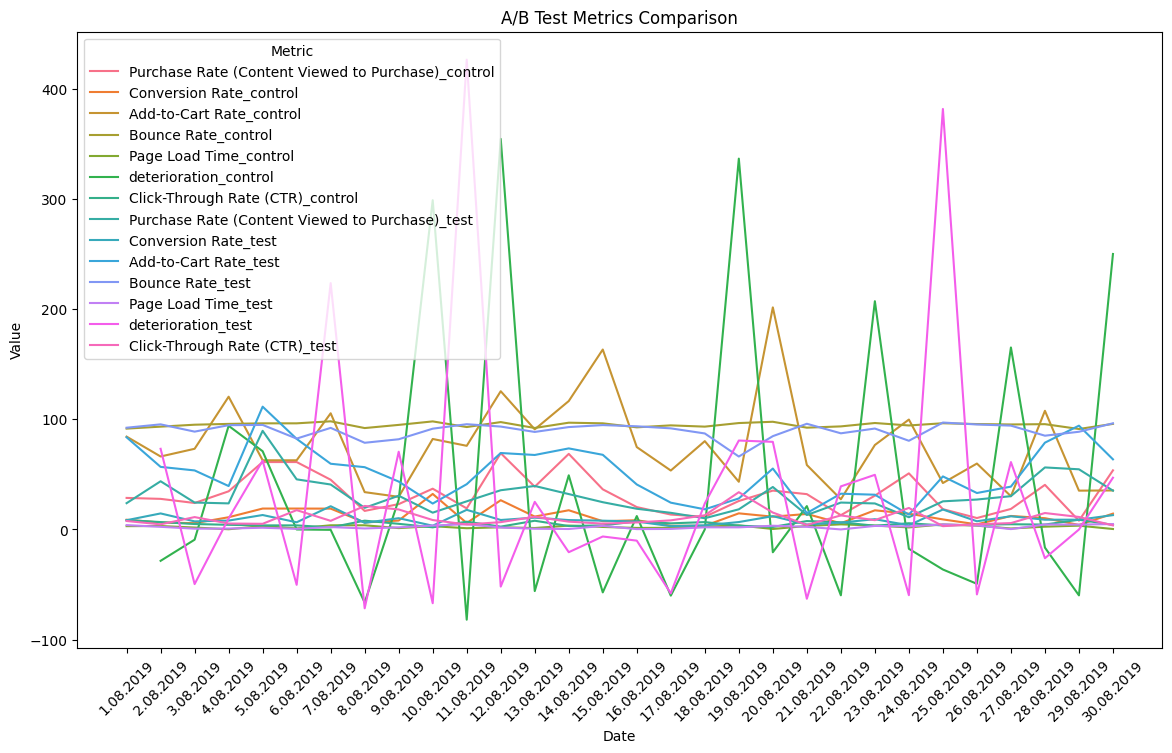

In [17]:
def run_one_sided_t_test(control_metric, test_metric, alternative):
    """Perform one-sided t-tests based on the alternative hypothesis."""
    diff = (df[test_metric] - df[control_metric]).dropna()
    stat, p_value = stats.ttest_1samp(diff, popmean=0, alternative=alternative)
    return stat, p_value

# Define metrics and their hypothesis types
metrics_to_test = {
    # Success metrics (H0: δ ≤ 0, H1: δ > 0)
    'Success': [
        ('Purchase Rate (Content Viewed to Purchase)_control', 
         'Purchase Rate (Content Viewed to Purchase)_test'),
        ('Conversion Rate_control', 'Conversion Rate_test')
    ],
    # Guardrail metrics (H0: δ ≤ -NIM, H1: δ > -NIM)
    'Guardrail': [
        ('Add-to-Cart Rate_control', 'Add-to-Cart Rate_test'),
        ('Bounce Rate_control', 'Bounce Rate_test'),
        ('Page Load Time​_control', 'Page Load Time​_test')
    ],
    # Deterioration metrics (H0: δ ≥ 0, H1: δ < 0)
    'Deterioration': [
        ('deterioration_control', 'deterioration_test'),
        ('Click-Through Rate (CTR)_control', 'Click-Through Rate (CTR)_test')
    ]
}

# Bonferroni correction
alpha = 0.05
total_tests = sum(len(v) for v in metrics_to_test.values())
adjusted_alpha = alpha / total_tests

# NIM and MDE values
NIM = 2    

print("\n--- One-Sided Test Results (with Bonferroni Correction) ---")
for test_type, metric_pairs in metrics_to_test.items():
    print(f"\n{test_type} Metrics:")
    for control_metric, test_metric in metric_pairs:
        if test_type == 'Success':
            alternative = 'greater'
        elif test_type == 'Guardrail':
            alternative = 'greater'  # Testing for no significant worsening beyond NIM
        else:  # Deterioration
            alternative = 'less'
        
        stat, p = run_one_sided_t_test(control_metric, test_metric, alternative)
        significance = "Significant" if p < adjusted_alpha else "Not Significant"
        print(f"{control_metric} vs {test_metric}: t-statistic = {stat:.4f}, p-value = {p:.4f}, {significance}")

# Visualize Results
df_long = df.melt(id_vars='Date', 
                  value_vars=[m[0] for t in metrics_to_test.values() for m in t] +
                             [m[1] for t in metrics_to_test.values() for m in t],
                  var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Date', y='Value', hue='Metric')
plt.xticks(rotation=45)
plt.title("A/B Test Metrics Comparison")
plt.show()


### Cohen D (Effect Size)

In [ ]:
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x)**2 + np.std(y)**2) / 2)

# Effect size for Conversion Rate
cohen_d_conversion_rate = cohen_d(df['Conversion Rate_control'], df['Conversion Rate_test'])
print(f"Cohen's d for Conversion Rate: {cohen_d_conversion_rate:.4f}")

# Effect size for Purchase Rate
cohen_d_purchase_rate = cohen_d(df['Purchase Rate (Content Viewed to Purchase)_control'], 
                                df['Purchase Rate (Content Viewed to Purchase)_test'])
print(f"Cohen's d for Purchase Rate: {cohen_d_purchase_rate:.4f}")


Effect size (Cohen's d) provides a standardized measure of the magnitude of the difference between the control and test groups. Cohen's d helps quantify the practical significance of your A/B test.

Conversion Rate: 0.4392 indicates a medium effect size. It suggest a moderate practical difference in conversion rates between the control and test groups, though not statistically significant based on p-value

Purchase Rate: 0.1151 indicates a small effect size, indicating only a minor difference in purchase rates between the groups

### Bayesian

In [ ]:
successes_control = df['Purchase_control'].sum()
trials_control = df['Website Clicks_control'].sum()

successes_test = df['Purchase_test'].sum()
trials_test = df['Website Clicks_test'].sum()

# Define the priors (Beta(1,1) since priors are unknown)
alpha_prior = 1
beta_prior = 1

# Compute the posterior
posterior_alpha_control = alpha_prior + successes_control
posterior_beta_control = beta_prior + (trials_control - successes_control)

posterior_alpha_test = alpha_prior + successes_test
posterior_beta_test = beta_prior + (trials_test - successes_test)

# Sample from the posterior distributions
samples_control = beta.rvs(posterior_alpha_control, posterior_beta_control, size=10000)
samples_test = beta.rvs(posterior_alpha_test, posterior_beta_test, size=10000)

# Calculate the probability that the test group is better than the control group
prob_test_better = (samples_test > samples_control).mean()

print(f"Probability that the test group is better than the control group: {prob_test_better:.4f}")

plt.figure(figsize=(10, 6))
x = np.linspace(0, 0.2, 1000)
plt.plot(x, beta.pdf(x, posterior_alpha_control, posterior_beta_control), label='Control Group', color='blue')
plt.plot(x, beta.pdf(x, posterior_alpha_test, posterior_beta_test), label='Test Group', color='green')
plt.title("Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.show()


The Bayesian approach indicates almost no probability that the test group is better than the control group. This confirms the frequentist results, showing that the changes applied to the test group did not result in improvements.